# 팀 스마일C 코드 제출
* 팀원: 정우섭, 김유민, 김유진, 장동언, 황정묵
* PRIVATE SCORE: 0.65887 
* PRIVATE RANKING: 36

# 개발 환경
* OS : 
* 라이브러리 버전 : 

# 0.Data Load

In [ ]:
!pip install catboost
!pip install lightgbm
!pip install optuna   

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 16.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 6.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt   
import seaborn as sns 

# model evaluation, preprocessing 
import sklearn
from sklearn import preprocessing, metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score, log_loss

# sequential model modeling 
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation
from keras import backend as K 
from keras import regularizers
from keras.layers import Dense,Dropout, Activation, BatchNormalization, Conv2D, Flatten  
from keras import optimizers, metrics, callbacks
from keras.backend import clear_session

# optuna Hyper-params tuning
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_contour

# ML classification models 
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifierCV
from xgboost import XGBClassifier

# Google Drive mount
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# seed fixing for reproduction 
import torch 
import random as rn 

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정
seed_num=37

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
seed_everything(37)
seed_num=37
seed=37

np.random.seed(seed_num)
rn.seed(seed_num) 
tf.random.set_seed(seed_num)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(config=session_conf)
K.set_session(sess)

class config:   
    seed = 37  
    device = "cuda:0"            

def seed_everything(seed: int = 37):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
seed_everything(config.seed)
tf.random.set_seed(37) # tensorflow global seed 
print(config.seed)     

37


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

train_x = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Class','Y_Quality'])
train_y = train_df['Y_Class']
test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])   

# 1.Data & Features

## 1.1 EDA

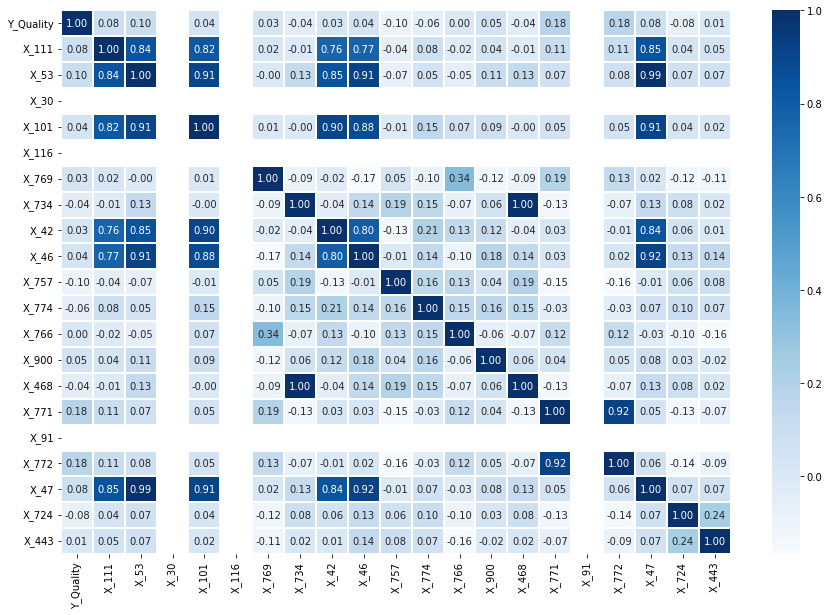

In [ ]:
# random 20 features list (모두 NaN인 컬럼 제외하고, 랜덤 20개 feature의 상관관계 히트맵)
Xs = train_df.iloc[:,4:].columns
null_count = train_df.isnull().sum().to_dict()
cols = pd.DataFrame({i for i in null_count if null_count[i]<250 and i in Xs})
cols_name = list(cols[0])  # not_all_NAN features name in list 

import random
a = ['Y_Quality']
for i in range(20):
    num = random.randint(1,2875)
    a.append(cols_name[i])

# heatmap: `random X features` and `Y_Quality` correlation
corr = train_df[a].corr()  # correlation matrix
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues', linewidths=2);

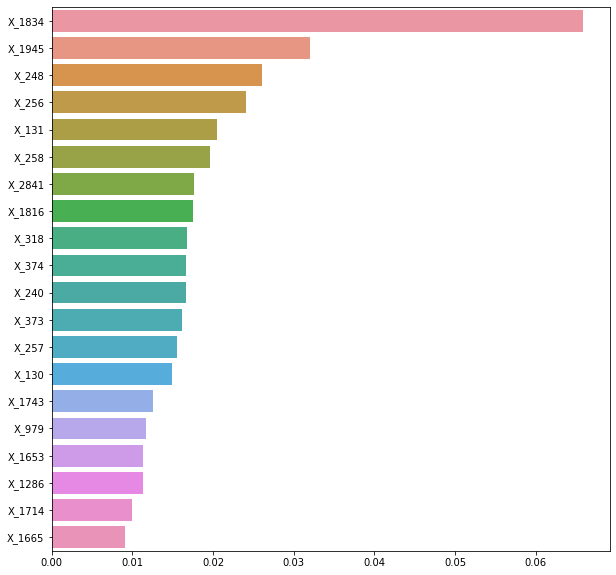

In [ ]:
# feature 중요도
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

qual_col = ['LINE', 'PRODUCT_CODE']
for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_x[i])
    train_x[i] = le.transform(train_x[i])
    for label in np.unique(test_x[i]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i])

train_x = train_x.fillna(0)
test_x = test_x.fillna(0)
X_train, X_test, y_train, y_test=train_test_split(train_x,train_y,test_size=0.3,random_state=seed_num)

%matplotlib inline
RF = RandomForestRegressor(random_state=0, max_depth=5, min_samples_leaf=8, min_samples_split=8,n_estimators=200)
RF.fit(X_train, y_train)
ftr_importances_values = RF.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top = ftr_importances.sort_values(ascending=False)[:20]
 
plt.figure(figsize=(10, 10))
sns.barplot(x=ftr_top, y=ftr_top.index)
plt.show()      

In [ ]:
ftr_top = pd.DataFrame(ftr_top)
ftr_top_idx = list(ftr_top.index)
x=train_x.loc[:,ftr_top_idx]
y=train_y

model = GradientBoostingClassifier(random_state=37).fit(X_train, y_train)
print('Done.')
y_pred = model.predict(X_test)
test_x=test_x.loc[:,ftr_top_idx]
preds = model.predict(test_x, y_pred)
sns.countplot(x=preds);      

Done.


TypeError: ignored

In [ ]:
# feature distribution 
train_x.describe()    

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
count,598.000000,598.000000,598.000000,598.000000,598.0,598.000000,598.000000,598.0,598.000000,598.000000,...,598.000000,598.000000,598.000000,598.000000,598.000000,598.000000,598.0,598.0,598.0,598.0
mean,3.214047,1.157191,1.406355,0.544265,0.0,0.583612,0.551383,0.0,0.459381,0.533141,...,0.141039,0.130564,0.137318,0.144148,0.139755,0.165552,0.0,0.0,0.0,0.0
std,1.703579,0.983298,4.655332,0.461135,0.0,0.493372,0.467361,0.0,0.392067,0.450953,...,0.318552,0.295577,0.310467,0.327595,0.312991,0.371989,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,2.000000,2.000000,0.892157,0.0,1.000000,0.909091,0.0,0.725806,0.909091,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,5.000000,2.000000,2.000000,0.931373,0.0,1.000000,0.909091,0.0,0.806452,0.909091,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,5.000000,2.000000,103.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='X_1712', ylabel='Count'>

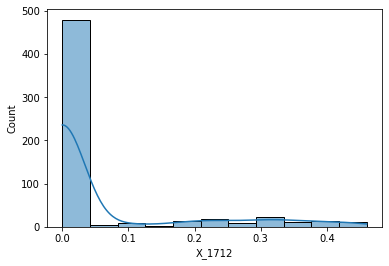

In [ ]:
# feature histogram with KDE (밀도그래프) 
# 임의의 feature에 대한 histplot + 밀도 곡선 출력
num = random.randint(1,2875)
sns.histplot(train_x[f'X_{num}'], kde=True)

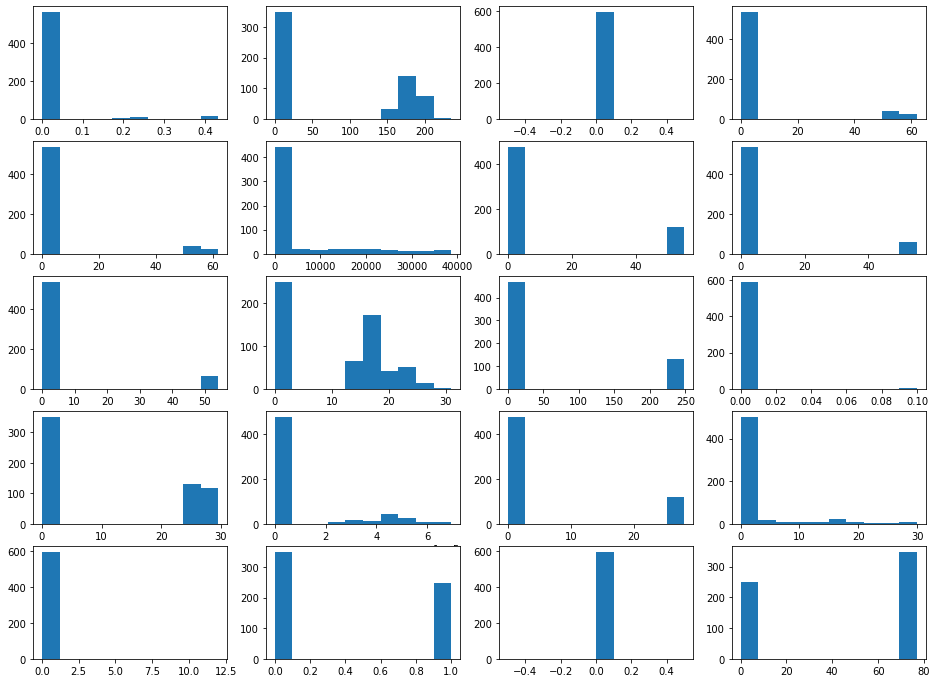

In [ ]:
# visualize random 20 features distribution 
# imbalanced feature distribution (NO Gaussian distribution shape) --> MinMaxscaler
fig, axes = plt.subplots(5,4,figsize=(16,12))
ax= axes.flatten()

for i in range(20): 
    num = random.randint(1,2875)
    ax[i].hist(train_x[f'X_{num}']);    

## 1.2 Preprocessing
1. Label Encoding: categorical values `LINE`, `PRODUCT_CODE`
2. Missing values: fillna(0) 
3. scaling: StandardScaler 

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

train_x = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Class','Y_Quality'])
train_y = train_df['Y_Class']
test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])   

In [ ]:
# 1) qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']
for i in qual_col:
    le = LabelEncoder()    # one-hot encoding (X): get_dummies(test_df) is not allowed (data leakage)   
    le = le.fit(train_x[i])
    train_x[i] = le.transform(train_x[i])
    for label in np.unique(test_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i]) 


In [ ]:
# 2) Missing Values 
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)

In [ ]:
# 3) MinMaxscaling: only `X_???` values (continuous)
Xs = train_x.select_dtypes(include=float).iloc[:,1:].columns.tolist()
scaler = MinMaxScaler().fit(train_x.loc[:, Xs])
train_x.loc[:, Xs] = scaler.transform(train_x.loc[:, Xs])
test_x.loc[:, Xs] = scaler.transform(test_x.loc[:, Xs])

X_train, X_test, y_train, y_test=train_test_split(train_x,train_y,test_size=0.3,random_state=seed_num)

# 2.Modeling

## 2.1 ML models
- 여러 Machine Learning Classifier 모델들의 test set Accuracy score 도출 
    - Ensemble에서 각 모델의 weight(가중치) 정하기 위한 근거로 사용하기 위함
1. RandomForestClassifier
2. GradientboostingClassiifer
3. XGBClassifier
4. LGBMClassifier
5. CatboostClassifier
6. RidgeClassifier
7. BaggingClassifier

In [ ]:
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

models = [
    RandomForestClassifier(random_state=seed_num), 
    GradientBoostingClassifier(random_state=seed_num),      
    XGBClassifier(random_state=seed_num),
    LGBMClassifier(objective='multiclass', random_state=seed_num),
    CatBoostClassifier(objective='MultiClass',
                                   task_type='GPU',
                                   one_hot_max_size=2, random_seed=seed_num,
                                   iterations=4000, verbose=False,
                                   learning_rate=0.05
                                   ),
    RidgeClassifierCV(),  # RidgeClassifier: no seed setting argument  
    BaggingClassifier(random_state=seed_num)]

In [ ]:
# find weights for each model 
model_list = ['RF', 'GBC', 'XGB', 'LGBM', 'Catboost', 'Ridge', 'Bagging']
i=0
model_acc = {}

for model in models:  
    if i == 4: 
        preds = model.fit(X_train, y_train).predict(X_test)
        preds = preds.reshape(1,180)
        preds = list(preds[0])
    else: 
        preds = model.fit(X_train, y_train).predict(X_test)

    globals()[f'preds_{model_list[i]}'] = preds   # set variable name for each model prediction results  
  
    score = sklearn.metrics.accuracy_score(y_test, preds)
    model_acc[model_list[i]] = score
    i += 1   

print(model_acc)   

{'RF': 0.7888888888888889, 'GBC': 0.8111111111111111, 'XGB': 0.7722222222222223, 'LGBM': 0.7888888888888889, 'Catboost': 0.8166666666666667, 'Ridge': 0.7611111111111111, 'Bagging': 0.75}


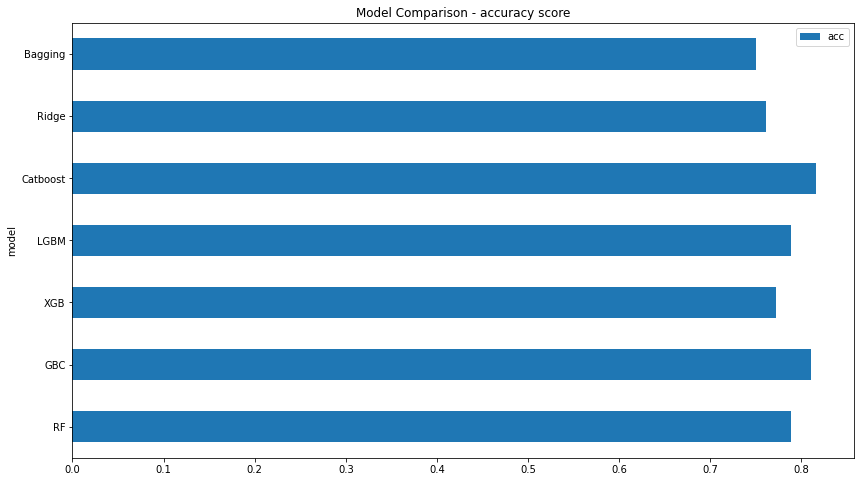

In [ ]:
# ML models accuracy comparison plot 
model_name = list(model_acc.keys())
model_acc = list(model_acc.values())
acc_dic = {'model': model_name, 'acc': model_acc}
acc_df = pd.DataFrame(acc_dic)
acc_df = acc_df.set_index('model')

acc_df.plot(kind='barh', figsize=(14,8),
            title='Model Comparison - accuracy score');

## 2.2 sequential MLP 

In [ ]:
import torch.nn as nn 
import torch.nn.functional as F 

class MultilayerPerceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
        """
        parameters: 
            input_dim (int): 입력 벡터 크기
            hidden_dim1 (int): 첫 번째 Linear 층의 출력 크기
            hidden_dim2 (int): 두 번째 Linear 층의 출력 크기 
            output_dim (int): 세 번째 Linear 층의 출력 크기 
        """
        super(MultilayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)

    def forward(self, x_in, apply_softmax=False):
        """
        MLP의 정방향 계산 

        parameters:
            x_in (torch.Tensor): 입력 데이터 텐서
                x_in.shape는 (batch, input_dim)
            apply_softmax (multiclasses): softmax activation function 
        return: 
            result Tensor
            tesnor.shape: (batch, output_dim)
        """
        intermediate1 = F.relu(self.fc1(x_in))   # activation function
        intermediate2 = F.relu(self.fc2(intermediate1))   # activation function
        intermediate3 = F.relu(self.fc3(intermediate2))   # activation function
        output = self.fc4(intermediate3)    


        if apply_softmax: 
            output = F.softmax(output, dim=1)   # output layer: softmax activation function
        return output 

In [ ]:
def describe(x): 
    print(f'Type: {x.type()}')
    print(f'shape: {x.shape}')
    # print(f'value: {x}') 

batch_size = 256 
input_dim = train_x.shape[-1]
hidden_dim1 = 1024
hidden_dim2 = 512
hidden_dim3 = 256
output_dim = 3 

# model design 
mlp = MultilayerPerceptron(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)
print(mlp)
x_input = torch.rand(batch_size, input_dim)
y_output = mlp(x_input, apply_softmax=True)  # result: probabilities format 
a = y_output
describe(y_output)

MultilayerPerceptron(
  (fc1): Linear(in_features=2877, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=3, bias=True)
)
Type: torch.FloatTensor
shape: torch.Size([256, 3])


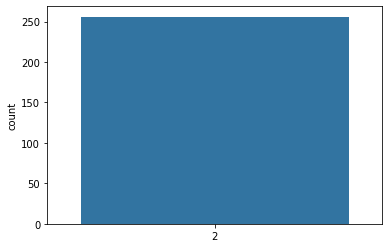

In [ ]:
prediction=[]

for i in a: 
    i = list(i)
    prediction.append(i.index(max(i)))

sns.countplot(x=prediction);    

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
submit['Y_Class'] = prediction

submit.to_csv('MLP-ANN-smartFactorySubmission.csv', index=False)     

# 3.Params Optimization
1. GridSearch 
2. Optuna
3. RandomizedSearchCV

## 3.1 GradientBoosting

In [ ]:
gb_class = GradientBoostingClassifier(random_state = 37) 

kf = KFold(n_splits=5, shuffle=True, random_state=37)

scores = cross_validate(gb_class, X_train, y_train, 
                        cv = kf, scoring = "accuracy", 
                        return_train_score = True, n_jobs = -1) 

In [ ]:
print(scores) 
scoring = scores['test_score'].mean()
print(f'Best Accuracy: {round(scoring, 2)*100}')  

{'fit_time': array([0.40023923, 0.41092181, 0.39718652, 0.42171001, 0.30059123]), 'score_time': array([0.00424504, 0.00317955, 0.00248575, 0.00245333, 0.00216508]), 'test_score': array([0.75      , 0.71428571, 0.69047619, 0.71084337, 0.69879518]), 'train_score': array([0.90419162, 0.90718563, 0.91317365, 0.92238806, 0.90746269])}
Best Accuracy: 71.0


In [ ]:
def objective(trial, X, y, cv, scoring):
  params = {
    "n_estimators": trial.suggest_int("n_estimators", 100, 5000, step = 100),
    "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log = True),
    "max_depth": trial.suggest_int("max_depth", 3, 9),
    "subsample": trial.suggest_float("subsample", 0.5, 0.9, step = 0.1),
    "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"]),
    "random_state": 42,
    }
  # Perform cross validation
  gb_class = GradientBoostingClassifier(**params)

  # Compute scores
  scores = cross_validate(gb_class, X, y, cv = cv, scoring = scoring, n_jobs = -1)
  accuracy = scores["test_score"].mean()

  return accuracy

In [ ]:
study = optuna.create_study(direction = "maximize")

kf = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=37)

func = lambda trial: objective(trial, X_train, y_train, 
                               cv = kf, scoring = "accuracy")

# %%time
# Start optimizing with 10 trials
study.optimize(func, n_trials = 10)

print(f"The highest accuracy reached by this study: {(study.best_value) * 100}%.")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")    

[I 2023-03-01 15:15:54,013] A new study created in memory with name: no-name-6926a03d-1efe-4862-95f6-591a38f14305
[W 2023-03-01 15:16:03,251] Trial 0 failed with parameters: {'n_estimators': 4000, 'learning_rate': 0.23414076793735694, 'max_depth': 3, 'subsample': 0.8, 'max_features': 'log2'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-66-03e1837b5db3>", line 5, in <lambda>
    func = lambda trial: objective(trial, X_train, y_train,
  File "<ipython-input-65-8a203aa46cbb>", line 26, in objective
    scores = cross_validate(gb_class, X, y, cv = cv, scoring = scoring, n_jobs = -1)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 267, in cross_validate
    results = parallel(
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", line 10

KeyboardInterrupt: ignored

In [ ]:
import imblearn

params= {'n_estimators': 4700, 'learning_rate': 0.004955208213721993, \
        'max_depth': 6, 'subsample': 0.7, 'max_features': 'auto'}
GBC =  GradientBoostingClassifier(random_state=37, **params,                              
                                  ).fit(train_x, train_y)
preds = GBC.predict(test_x)
sns.countplot(x=preds);
preds

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- LINE
- PRODUCT_CODE
- X_1
- X_10
- X_100
- ...

  warnings.warn(message, FutureWarning)


ValueError: ignored

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
submit['Y_Class'] = preds

submit.to_csv('GBCoptuna-smartFactorySubmission.csv', index=False)

### GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV

estimator = GradientBoostingClassifier(random_state = 37)

param_grid = {
            'n_estimators' : [n_estimators for n_estimators in range(100, 5000, 100)],
            'learning_rate' : [lr * 0.0001 for lr in range(1, 10)],
            'max_depth' : [depth for depth in range(3, 9)],
            'subsample' : [subsample * 0.1 for subsample in range(5, 9, 1)],
            'max_features' : ['auto', 'sqrt', 'log2']
            }

# scoring = 'r2' -> 결정계수로 scoring
grid_GBC = GridSearchCV(estimator, param_grid, scoring = 'r2', n_jobs = -1)
grid_GBC.fit(train_x, train_y)

print('best estimator model: \n{}'.format(grid_GBC.best_estimator_))
print('\nbest parameter: \n{}'.format(grid_GBC.best_params_))
print("\nbest score: \n{}".format(grid_GBC.best_score_.round(3)))

## 3.2 CatBoost

In [ ]:
def objective(trial):
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred, average='macro')
     
# hyper-parameter tuning with OPTUNA  
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=37)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=10)  

In [ ]:
print("Number of trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ",trial.params)

model = CatBoostClassifier(**trial.params, verbose=False, random_state = 37)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [ ]:
params=  {'iterations': 857, 'learning_rate': 0.07097207730593516, 'depth': 8, \
        'l2_leaf_reg': 0.00012090525126196811, 'bootstrap_type': 'Bayesian', \
        'random_strength': 5.359110894800412, 'bagging_temperature': 0.7137022569955509, \
        'od_type': 'IncToDec', 'od_wait': 42}
CBC = CatBoostClassifier(**params, verbose=False, random_state=37)
CBC.fit(X_train, y_train)
y_pred = model.predict(test_x)
sns.countplot(x = y_pred);
preds

In [ ]:
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_contour

plot_optimization_history(study)

In [ ]:
plot_param_importances(study)

In [ ]:
import pickle
pickle.dump(model, open("catboost_model.pkl", "wb"))
     

optuna.visualization.plot_optimization_history(study)
     

optuna.visualization.plot_parallel_coordinate(study)
     

# 각 파라미터들의 상관관계
optuna.visualization.plot_contour(
    study,
    params=[
        "iterations",
        "learning_rate",
        "depth",
        "l2_leaf_reg",
        "bootstrap_type",
        "random_strength",
        "bagging_temperature",
        "od_type",
        "od_wait"
        ],
)

In [ ]:
# 하이퍼파라미터 중요도
optuna.visualization.plot_param_importances(study)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

GBC_model = GradientBoostingClassifier(n_estimators= 200, 
                                       learning_rate=0.21851112508358236, 
									max_depth= 6,
									subsample= 0.7, 
									max_features= 'auto').fit(X_train, y_train) 

In [ ]:
preds = GBC_model.predict(test_x)
print('Done.')
sns.countplot(x=preds); 

In [ ]:
from sklearn.model_selection import GridSearchCV

estimator = CatBoostClassifier(random_state = 37)

param_grid = {
            'iterataions' : [iter for iter in range(100, 1000, 100)],
            'learning_rate' : [lr * 0.0001 for lr in range(1, 10)],
            'depth' : [depth for depth in range(4, 10)],
            'l2_leaf_reg' : [leaf * 0.0000001 for leaf in range(1, 100, 10)],
            'bootstrap_type' : ['Bayesian'],
            'random_strength' : [strength * 0.1 for strength in range(1, 100, 10)],
            'bagging_temperature' : [bag * 0.1 for bag in range(1, 10)],
            'od_type' : ['IncToDec', 'Iter'],
            'od_wait' : [wait for wait in range(10, 50, 4)]
            }

# scoring = 'r2' -> 결정계수로 scoring
grid_CBC = GridSearchCV(estimator, param_grid, scoring = 'r2', n_jobs = -1)
grid_CBC.fit(X_train, y_train)

print('best estimator model: \n{}'.format(grid_CBC.best_estimator_))
print('\nbest parameter: \n{}'.format(grid_CBC.best_params_))
print("\nbest score: \n{}".format(grid_CBC.best_score_.round(3)))

## 3.3 MLP

In [ ]:
import torch

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.labels = [0 if label == 0 else 1 for label in df['HeartDisease']]
        self.features = df.drop(columns=['HeartDisease'], axis=1).values.tolist()

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_features(self, idx):
        return np.array(self.features[idx])

    def __getitem__(self, idx):
        batch_features = self.get_batch_features(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_features, batch_y

In [ ]:
def objective(trial):

    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              'n_unit': trial.suggest_int("n_unit", 4, 18)
              }
    
    model = build_model(params)
    
    accuracy = train_and_evaluate(params, model)

    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=30)

In [ ]:
def build_model(params):
    
    in_features = train_x.shape[-1]
    
    return nn.Sequential(
    
        nn.Linear(in_features, params['n_unit']),
        nn.LeakyReLU(),

        nn.Linear(params['n_unit'], 2),
        nn.LeakyReLU()
        
    )
 

In [ ]:

# Train and evaluate the accuarcy of neural network model
def train_and_evaluate(param, model):
    
    df = pd.read_csv('heart.csv')
    df = pd.get_dummies(df)
    
    train_data, val_data = train_test_split(df, test_size = 0.2, random_state = 42)
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = getattr(optim, param['optimizer'])(model.parameters(), lr= param['learning_rate'])

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(EPOCHS):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in train_dataloader:

                train_label = train_label.to(device)
                train_input = train_input.to(device)

                output = model(train_input.float())
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    val_input = val_input.to(device)

                    output = model(val_input.float())

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            accuracy = total_acc_val/len(val_data)

    return accuracy
  
 # Define a set of hyperparameter values, build the model, train the model, and evaluate the accuracy 
def objective(trial):

     params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              'n_unit': trial.suggest_int("n_unit", 4, 18)
              }
    
     model = build_model(params)
    
     accuracy = train_and_evaluate(params, model)

     return accuracy

# 4.Ensemble

## 4.1 VotingClassifier
1. Cross-Validation 구축 후 성능 비교

In [ ]:
models = [
    # test set accuracy 1위(0.8166) 
    CatBoostClassifier(verbose=False, random_seed=seed_num),
    # test set accuracy 5위(0.7722)
    XGBClassifier(random_state=seed_num),
    # test set accuracy 2위(0.8111) 
    GradientBoostingClassifier(random_state=seed_num)]

fit = [x.fit(train_x, train_y) for x in models]    

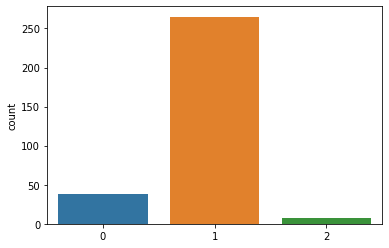

In [ ]:
def prediction(models, test, mode=None, weights=None):
    if mode == "hard":
        preds = np.asarray([x.predict(test).reshape(-1) for x in models]).T
        res = np.apply_along_axis(
            lambda x: np.argmax(np.bincount(x, weights=weights)),
            axis=1,
            arr=preds
        )
    elif mode == "soft":  
        preds = np.asarray([x.predict_proba(test) for x in models])
        res = np.zeros(preds[0].shape)
        for pred, weight in zip(preds, weights):
            res = res + pred*weight
        res = np.argmax(preds, axis=0) 
    else:
        res = models[0].predict(test)
    return res

preds = prediction(models, test_x, 'hard', [2,1,2] )

sns.countplot(x=preds);   

## 4.2 Score

In [ ]:
cbc = CatBoostClassifier(verbose=False, random_seed=seed_num)  
xgb = XGBClassifier(random_state=seed_num) 
gbc = GradientBoostingClassifier(random_state=seed_num) 
voting_model = VotingClassifier(estimators=[
                ('CatBoostClassifier', cbc),
                ('XGBClassifier', xgb),
                ('GradientBoostingClassifier', gbc)], 
                voting='hard', weights=[2,1,2])
# fitted = np.asarray(voting_model.fit(X_train, y_train).reshape(-1))
np.asarray(fitted)   

array(VotingClassifier(estimators=[('CatBoostClassifier',
                              <catboost.core.CatBoostClassifier object at 0x7f3f517db0d0>),
                             ('XGBClassifier',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                     

In [ ]:
val_preds = prediction(models, X_test, 'hard', [2,1,2])
val_score= sklearn.metrics.accuracy_score(y_test, val_preds)
val_score  

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_voting.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([est.predict(X) for est in self.estimators_]).T
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_scorer.py", line 

# 5.Submit

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

submit['Y_Class'] = preds
submit.to_csv('CXG212(1)-smartFactorySubmission.csv', index=False)  
sns.countplot(x=preds);
submit.Y_Class.value_counts()